In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pandas as pd

### Leggo i dati

In [3]:
data = pd.read_csv("network.tsv", delimiter = '\t')
data = data.to_numpy()
data = data[ np.arange(len(data)) != (data[:,0] == "# Disease(MESH)").argmax() ]
data

array([['MESH:D005923', 'DB00564'],
       ['MESH:D009503', 'DB01072'],
       ['MESH:D016115', 'DB01759'],
       ...,
       ['MESH:D010518', 'DB04216'],
       ['MESH:D002653', 'DB02701'],
       ['MESH:D013119', 'DB04465']], dtype=object)

### Costruisco $B_{train}$ e $B_{test}$
Le matrici hanno $1$ in presenza di link e $-1$ in assenza. $B_{train}$ possiede inoltre degli elementi nulli che rappresentano i link incogniti

In [4]:
proporzione_train_test = 0.99

diseases  = np.unique(data[:,0])
chemicals = np.unique(data[:,1])

B_train = np.ones((len(diseases), len(chemicals))) * -1.
B_test  = np.ones((len(diseases), len(chemicals))) * -1.

print("Costruisco B_train e B_test")

for i,t in enumerate(data):
    if i % 10000 == 0:
        print( "%.2f %%" % (100 * (1. * i) / len(data)) )
    dis  = t[0]
    chem = t[1]

    idx_dis  = np.argmax(diseases == dis)
    idx_chem = np.argmax(chemicals == chem)
    B_test[idx_dis, idx_chem] = 1.
    B_train[idx_dis, idx_chem] = 1.

print("censuro alcune entries in B_train")

censor_mask = np.random.choice(2, size = B_train.shape , p = np.array([1 - proporzione_train_test, proporzione_train_test]))
B_train *= censor_mask

Costruisco B_train e B_test
0.00 %
2.14 %
4.29 %
6.43 %
8.57 %
10.71 %
12.86 %
15.00 %
17.14 %
19.29 %
21.43 %
23.57 %
25.71 %
27.86 %
30.00 %
32.14 %
34.29 %
36.43 %
38.57 %
40.72 %
42.86 %
45.00 %
47.14 %
49.29 %
51.43 %
53.57 %
55.72 %
57.86 %
60.00 %
62.14 %
64.29 %
66.43 %
68.57 %
70.72 %
72.86 %
75.00 %
77.14 %
79.29 %
81.43 %
83.57 %
85.72 %
87.86 %
90.00 %
92.14 %
94.29 %
96.43 %
98.57 %
censuro alcune entries in B_train


# Regression of probability

In [5]:
def predict(V,W, temp):
    VWT = jax.vmap(lambda v: jax.vmap(lambda w:  v @ w  )(W))(V)
    return jnp.tanh( temp * VWT )

def loss(V,W,B, temp = 1.):
    #                 annulla il test set                                media sugli elementi non nulli
    #                ,-------'------,                               ,-------'-------,
    return  jnp.sum( jnp.abs(B)        * (predict(V,W, temp) - B)**2 )  / jnp.abs(B).sum() 

def loss2(V,W,B, temp = 1.):
     return  1. - jnp.sum( jnp.abs(B)        * (predict(V,W, temp) * B ) )  / jnp.abs(B).sum()    
    
def loss3(V,W,B, temp = 1.):
    BALANCE = (B == 1.) * ( (B == -1).sum() / (jnp.abs(B).sum())) + (B == -1.) * ( (B == +1).sum() / (jnp.abs(B).sum())) 
    return  jnp.sum( jnp.abs(B)        * (predict(V,W, temp) - B)**2 * BALANCE )  / jnp.abs(BALANCE).sum() 

    
loss = jax.jit(loss3)
grad = jax.jit(jax.grad(loss, argnums = (0,1)))
m = 3
V = np.random.randn(len(diseases), m)
W = np.random.randn(len(chemicals),m)
print(loss(V,W,B_train))

1.5324421


In [6]:
m = 50
np.random.seed(123)
V = np.random.randn(len(diseases), m)
W = np.random.randn(len(chemicals),m)
alfa = 10.
T = 1e-1
for i in range(500):     # 500
    T = (1. + 1e-3) * T   # 1e-3
    G = grad(V,W,B_train, temp = T)
    newV = V - alfa * G[0]
    newW = W - alfa * G[1]
    if(loss(newV,newW,B_train) < loss(V,W,B_train)):
        alfa *= 1.1
        V = newV
        W = newW
    else:
        alfa *= 0.5
    if i % 20 == 0:
        print(loss(V,W,B_train), loss(V,W,B_test * (B_train == 0) ), T )

1.8872676 1.8855656 0.1001
1.8848884 1.8851105 0.10212113360054008
1.8680131 1.8816156 0.10418307620239121
1.4884727 1.5706785 0.10628665178601042
0.29450145 0.3377041 0.1084327009689636
0.17792864 0.2906436 0.11062208134184763
0.14069133 0.2771364 0.11285566781099542
0.10259163 0.2804368 0.11513435294810027
0.09980316 0.2826002 0.11745904734689995
0.09943018 0.2827771 0.11983067998706232
0.09573906 0.2850255 0.12225019860541815
0.08086456 0.2926109 0.12471857007469002
0.07291541 0.30014914 0.12723678078986755
0.06637936 0.3101891 0.12980583706238458
0.060846347 0.31777892 0.1324267655222549
0.06082856 0.31779975 0.13510061352832758
0.060509995 0.3184547 0.137828449586826
0.05926368 0.32071695 0.14061136377833727
0.055032216 0.3267677 0.14345046819342383
0.053157672 0.33053875 0.1463468973770296
0.049814876 0.33596885 0.14930180878185986
0.04971328 0.3362607 0.15231638323091506
0.048974596 0.33825126 0.1553918253893641
0.04629027 0.34264275 0.15852936424594458
0.04552232 0.3443142 0.16

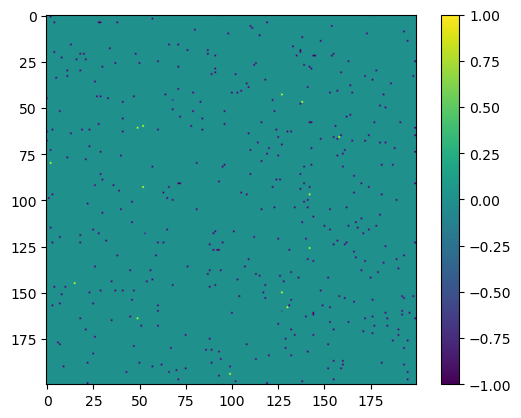

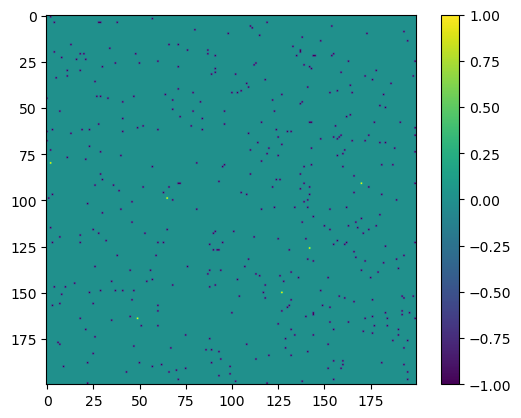

In [7]:
B_hat = predict(V,W,1.)
plt.imshow((B_hat * (B_train == 0.))[150:350,150:350] )
plt.colorbar()
plt.figure()
plt.imshow((B_test * (B_train == 0.))[150:350,150:350] )
plt.colorbar()

## Confusion Matrix

## Test set

<AxesSubplot:>

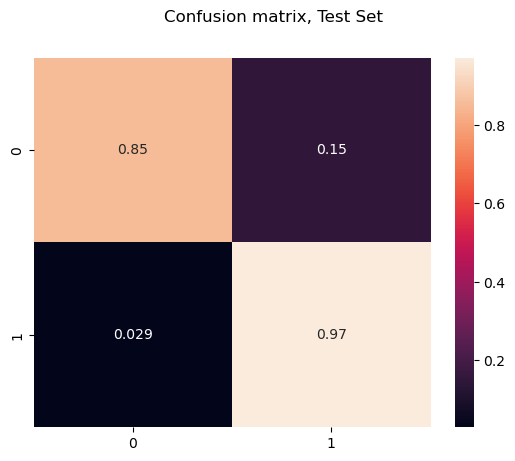

In [8]:
th = - 0.
TP = (((B_test * B_hat) >= th) * (B_test ==   1))[B_train == 0.].sum() / (B_test == 1.)[B_train == 0.].sum() 
FN = (((B_test * B_hat) <  th) * (B_test ==   1))[B_train == 0.].sum() / (B_test == 1.)[B_train == 0.].sum()
TN = (((B_test * B_hat) >= th) * (B_test ==  -1))[B_train == 0.].sum() / (B_test ==-1.)[B_train == 0.].sum() 
FP = (((B_test * B_hat) <  th) * (B_test ==  -1))[B_train == 0.].sum() / (B_test ==-1.)[B_train == 0.].sum()
import seaborn as sns
C = np.array( [  
                    [TP, FN], 
                    [FP, TN]
] )
plt.suptitle("Confusion matrix, Test Set")
sns.heatmap(C,annot = True)

## Training set

<AxesSubplot:>

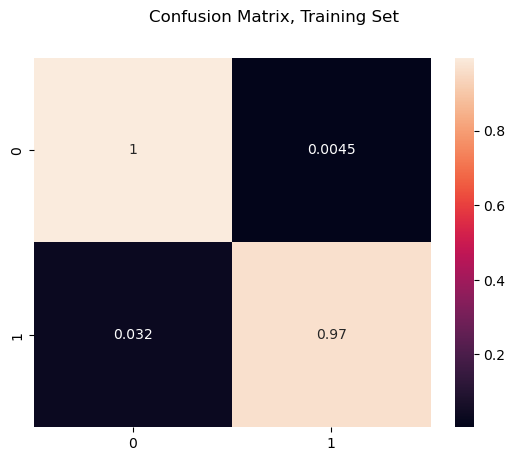

In [14]:
th = 0.
TP = (((B_train * B_hat) >= th) * (B_train ==   1))[B_train != 0.].sum() / (B_train == 1.)[B_train != 0.].sum() 
FN = (((B_train * B_hat) < th) * (B_train ==   1))[B_train != 0.].sum() / (B_train == 1.)[B_train != 0.].sum()
TN = (((B_train * B_hat) >= th) * (B_train ==  -1))[B_train != 0.].sum() / (B_train ==-1.)[B_train != 0.].sum() 
FP = (((B_train * B_hat) < th) * (B_train ==  -1))[B_train != 0.].sum() / (B_train ==-1.)[B_train != 0.].sum()
import seaborn as sns
C = np.array( [  
                    [TP, FN], 
                    [FP, TN]
] )
plt.suptitle("Confusion Matrix, Training Set")
sns.heatmap(C,annot = True)

In [98]:
(B_hat * B_test)[B_train == 0].sum() / (B_train == 0).sum()

DeviceArray(0.95973575, dtype=float32)

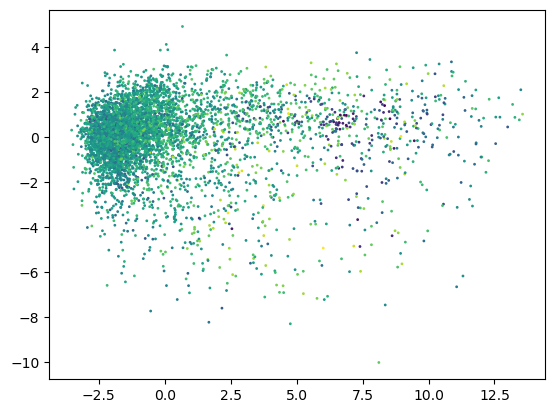

In [9]:
V_zc = V - V.mean(axis = 0)
U,s,Vt = np.linalg.svd(V_zc, full_matrices = False)
V_proj = V_zc @ Vt.T
plt.scatter(V_proj[:,0],V_proj[:,1], s = 1., c=  V_proj[:,2] )

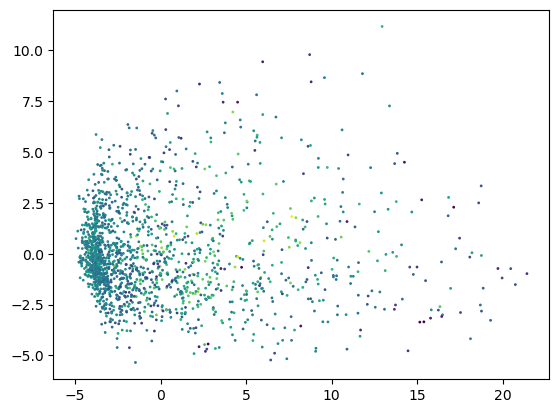

In [10]:
W_zc = W - W.mean(axis = 0)
U,s,Vt = np.linalg.svd(W_zc, full_matrices = False)
W_proj = W_zc @ Vt.T
plt.scatter(W_proj[:,0],W_proj[:,1], s = 1., c = W_proj[:,2])

# Topological similarity approach

Approccio "delle slide"

### Data retrieve

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pandas as pd

In [18]:
data = pd.read_csv("network.tsv", delimiter = '\t')
data = data.to_numpy()
data = data[ np.arange(len(data)) != (data[:,0] == "# Disease(MESH)").argmax() ]
data

array([['MESH:D005923', 'DB00564'],
       ['MESH:D009503', 'DB01072'],
       ['MESH:D016115', 'DB01759'],
       ...,
       ['MESH:D010518', 'DB04216'],
       ['MESH:D002653', 'DB02701'],
       ['MESH:D013119', 'DB04465']], dtype=object)

In [19]:
diseases  = np.unique(data[:,0])
chemicals = np.unique(data[:,1])

B = np.zeros((len(diseases), len(chemicals)))

for i,t in enumerate(data):
    if i % 10000 == 0:
        print( "%.2f %%" % (100 * (1. * i) / len(data)) )
    dis  = t[0]
    chem = t[1]

    idx_dis  = np.argmax(diseases == dis)
    idx_chem = np.argmax(chemicals == chem)
    B[idx_dis, idx_chem] = 1.

0.00 %
2.14 %
4.29 %
6.43 %
8.57 %
10.71 %
12.86 %
15.00 %
17.14 %
19.29 %
21.43 %
23.57 %
25.71 %
27.86 %
30.00 %
32.14 %
34.29 %
36.43 %
38.57 %
40.72 %
42.86 %
45.00 %
47.14 %
49.29 %
51.43 %
53.57 %
55.72 %
57.86 %
60.00 %
62.14 %
64.29 %
66.43 %
68.57 %
70.72 %
72.86 %
75.00 %
77.14 %
79.29 %
81.43 %
83.57 %
85.72 %
87.86 %
90.00 %
92.14 %
94.29 %
96.43 %
98.57 %


In [20]:
proporzione_train_test = 0.9
validation_set = np.random.choice(2, size = B_train.shape , p = np.array([1 - proporzione_train_test, proporzione_train_test]))
validation_set

array([[1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 0, 1, ..., 1, 1, 1]])

### Definisco la matrice delle similaritá

In [21]:
S = jax.jit(
    jax.vmap(
    lambda a:
    jax.vmap(
        lambda b:
            ((a > 0.5) *1.) @ (( b > 0.5) * 1.)
    )(B)
))(B)
S = B@B.T

In [22]:
B_hat = jax.vmap(
                lambda s:
                    jax.vmap(
                        lambda b: 
                            (s.sum() > 0.) * ((s @ b) / (s.sum()))
                    )
                    (B.T)
            )(S)

jnp.linalg.norm( (B_hat  - B)*validation_set )

DeviceArray(736.2, dtype=float32)

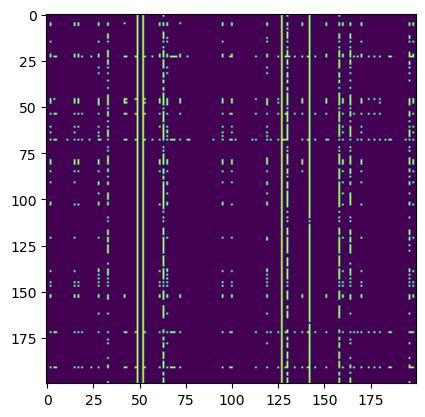

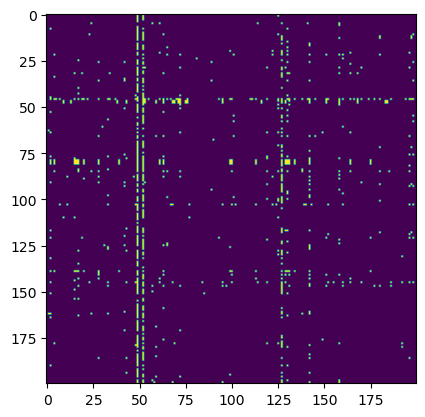

In [24]:
plt.imshow(B_hat[150:350,150:350] > 0.5)
plt.figure()
plt.imshow(B[150:350,150:350] > 0.5)

<AxesSubplot:>

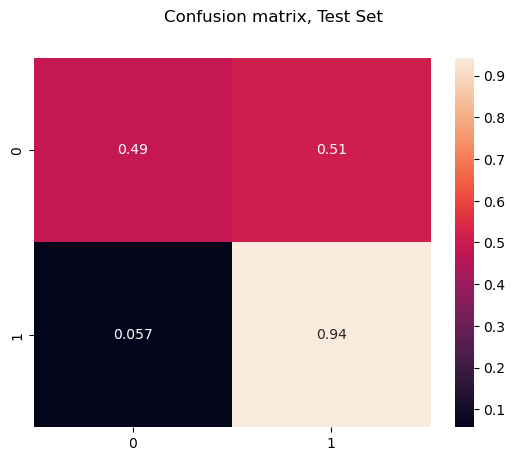

In [154]:
TP = (((B_hat > 0.5) * (B > 0.5)) * validation_set).sum() / (((B > 0.5)) * validation_set).sum()
FN = (((B_hat < 0.5) * (B > 0.5)) * validation_set).sum() / (((B > 0.5)) * validation_set).sum()
TN = (((B_hat < 0.5) * (B < 0.5)) * validation_set).sum() / (((B < 0.5)) * validation_set).sum()
FP = (((B_hat > 0.5) * (B < 0.5)) * validation_set).sum() / (((B < 0.5)) * validation_set).sum()

import seaborn as sns
C = np.array( [  
                    [TP, FN], 
                    [FP, TN]
] )
plt.suptitle("Confusion matrix, Test Set")
sns.heatmap(C,annot = True)

# Distribution of estimator

### Carico i dati

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pandas as pd

In [12]:
data = pd.read_csv("network.tsv", delimiter = '\t')
data = data.to_numpy()
data = data[ np.arange(len(data)) != (data[:,0] == "# Disease(MESH)").argmax() ]

diseases  = np.unique(data[:,0])
chemicals = np.unique(data[:,1])

B_test  = np.ones((len(diseases), len(chemicals))) * -1.

print("Costruisco B_test")

for i,t in enumerate(data):
    if i % 10000 == 0:
        print( "%.2f %%" % (100 * (1. * i) / len(data)) )
    dis  = t[0]
    chem = t[1]

    idx_dis  = np.argmax(diseases == dis)
    idx_chem = np.argmax(chemicals == chem)
    B_test[idx_dis, idx_chem]  = 1.

Costruisco B_test
0.00 %
2.14 %
4.29 %
6.43 %
8.57 %
10.71 %
12.86 %
15.00 %
17.14 %
19.29 %
21.43 %
23.57 %
25.71 %
27.86 %
30.00 %
32.14 %
34.29 %
36.43 %
38.57 %
40.72 %
42.86 %
45.00 %
47.14 %
49.29 %
51.43 %
53.57 %
55.72 %
57.86 %
60.00 %
62.14 %
64.29 %
66.43 %
68.57 %
70.72 %
72.86 %
75.00 %
77.14 %
79.29 %
81.43 %
83.57 %
85.72 %
87.86 %
90.00 %
92.14 %
94.29 %
96.43 %
98.57 %


### Funzione di cross validazione

In [4]:
def confusion_matrix(B_train, B_hat, B_test):
    th = - 0.
    TP = (((B_test * B_hat) >= th) * (B_test ==   1))[B_train == 0.].sum() / (B_test == 1.)[B_train == 0.].sum() 
    FN = (((B_test * B_hat) <  th) * (B_test ==   1))[B_train == 0.].sum() / (B_test == 1.)[B_train == 0.].sum()
    TN = (((B_test * B_hat) >= th) * (B_test ==  -1))[B_train == 0.].sum() / (B_test ==-1.)[B_train == 0.].sum() 
    FP = (((B_test * B_hat) <  th) * (B_test ==  -1))[B_train == 0.].sum() / (B_test ==-1.)[B_train == 0.].sum()
    
    C = np.array([  
                        [TP, FN], 
                        [FP, TN]
    ])
    
    return C

In [29]:
def packet_cross_validation(m, B_test): # m = dimensione dello spazio dei pacchetti
    
    # definisco la funzione di predizione
    def predict(V,W, temp):
        VWT = jax.vmap(lambda v: jax.vmap(lambda w:  v @ w  )(W))(V)
        return jnp.tanh( temp * VWT )
    
    # definisco la funzione di loss
    def loss(V,W,B, temp = 1.):
        BALANCE = (B == 1.) * ( (B == -1).sum() / (jnp.abs(B).sum())) + (B == -1.) * ( (B == +1).sum() / (jnp.abs(B).sum())) 
        return  jnp.sum( jnp.abs(B)        * (predict(V,W, temp) - B)**2 * BALANCE )  / jnp.abs(BALANCE).sum() 
    loss = jax.jit(loss)
    
    # definisco il suo gradiente
    grad = jax.jit(jax.grad(loss, argnums = (0,1)))



    proporzione_train_test = 0.95
    censor_mask = np.random.choice(2, size = B_test.shape , p = np.array([1 - proporzione_train_test, proporzione_train_test]))
    B_train     = B_test * censor_mask
    
    V = np.random.randn(len(diseases), m)
    W = np.random.randn(len(chemicals),m)
    
    alfa = 10.
    T = 1e-1
    for i in range(500):      # 500
        T = (1. + 1e-3) * T   # 1e-3
        G = grad(V,W,B_train, temp = T)
        newV = V - alfa * G[0]
        newW = W - alfa * G[1]
        if(loss(newV,newW,B_train) < loss(V,W,B_train)):
            alfa *= 1.1
            V = newV
            W = newW
        else:
            alfa *= 0.5
            
    # compute distance between identity matrix and covariance matrix
    B_hat = predict(V,W,1.)
    C     = confusion_matrix(B_train, B_hat, B_test) 
    return C

In [30]:
confusions = []
for i in range(100):
    print("test %d" % i)
    confusions.append( packet_cross_validation(10, B_test))

test 0
test 1
test 2
test 3
test 4
test 5
test 6
test 7
test 8
test 9
test 10
test 11
test 12
test 13
test 14
test 15
test 16
test 17
test 18
test 19
test 20
test 21
test 22
test 23
test 24
test 25
test 26
test 27
test 28
test 29
test 30
test 31
test 32
test 33
test 34
test 35
test 36
test 37
test 38
test 39
test 40
test 41
test 42
test 43
test 44
test 45
test 46
test 47
test 48
test 49
test 50
test 51
test 52
test 53
test 54
test 55
test 56
test 57
test 58
test 59
test 60
test 61
test 62
test 63
test 64
test 65
test 66
test 67
test 68
test 69
test 70
test 71
test 72
test 73
test 74
test 75
test 76
test 77
test 78
test 79
test 80
test 81
test 82
test 83
test 84
test 85
test 86
test 87
test 88
test 89
test 90
test 91
test 92
test 93
test 94
test 95
test 96
test 97
test 98
test 99


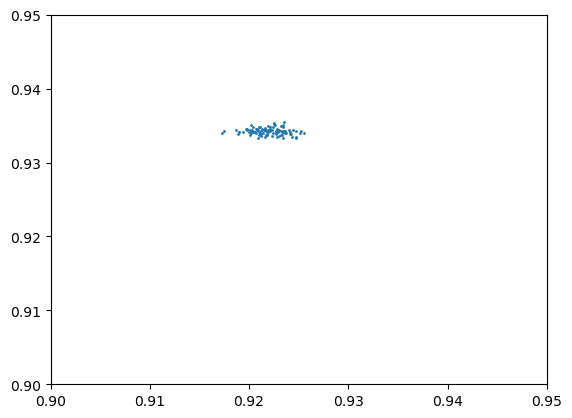

In [38]:
confusions_points = []
for c in confusions:
    confusions_points.append(np.array([ c[0,0], c[1,1] ]))
confusions_points = np.array(confusions_points)
plt.xlim(0.90,0.95)
plt.ylim(0.90,0.95)
plt.scatter(confusions_points[:,0], confusions_points[:,1], s = 1.)

# $\epsilon$ animation

In [17]:
# definisco la funzione di predizione
def predict(V,W, temp):
    VWT = jax.vmap(lambda v: jax.vmap(lambda w:  v @ w  )(W))(V)
    return jnp.tanh( temp * VWT )

# definisco la funzione di loss
def loss(V,W,B, temp = 1.):
    BALANCE = (B == 1.) * ( (B == -1).sum() / (jnp.abs(B).sum())) + (B == -1.) * ( (B == +1).sum() / (jnp.abs(B).sum())) 
    return  jnp.sum( jnp.abs(B)        * (predict(V,W, temp) - B)**2 * BALANCE )  / jnp.abs(BALANCE).sum() 

loss = jax.jit(loss)
    
def epsilon_animation(m, epsilon, gamma):
    
    # definisco il suo gradiente
    grad = jax.jit(jax.grad(loss, argnums = (0,1)))

    # fisso il seed
    np.random.seed(123)
    
    proporzione_train_test = 0.95
    censor_mask = np.random.choice(2, size = B_test.shape , p = np.array([1 - proporzione_train_test, proporzione_train_test]))
    B_train     = B_test * censor_mask
    
    V = np.random.randn(len(diseases), m)
    W = np.random.randn(len(chemicals),m)
    
    alfa = 10.
    T = epsilon
    Vs = list()
    Ws = list()
    for i in range(300):      # 500
        
        Vs.append(V)
        Ws.append(W)
        
        T = (1. + gamma) * T   # 1e-3
        G = grad(V,W,B_train, temp = T)
        newV = V - alfa * G[0]
        newW = W - alfa * G[1]
        if(loss(newV,newW,B_train) < loss(V,W,B_train)):
            alfa *= 1.1
            V = newV
            W = newW
        else:
            alfa *= 0.5
        if i % 10 == 0:
            print(i)
            
    # compute distance between identity matrix and covariance matrix
    return Vs,Ws

In [23]:
Vs,Ws = epsilon_animation(2, 5e-3, 6e-4)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


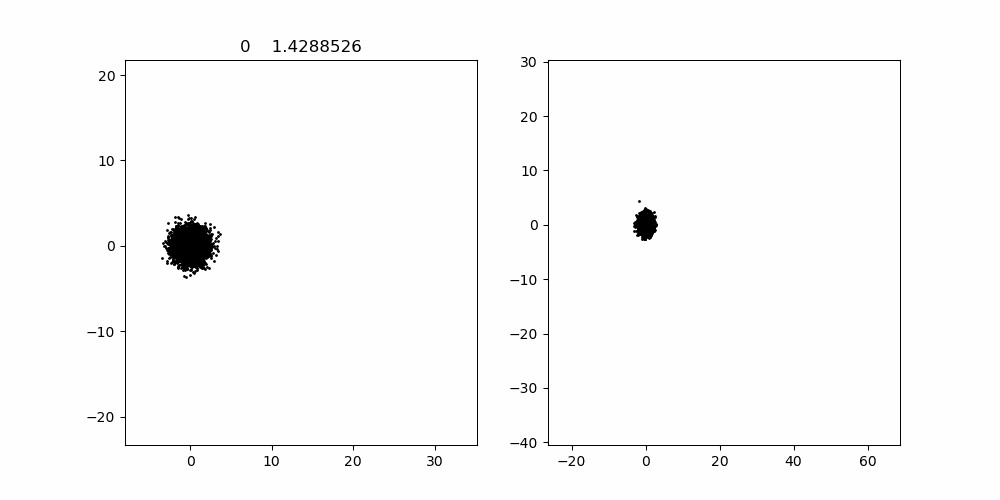

In [24]:
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

fig = plt.figure(figsize=(10,5))
axs  = fig.subplots(1,2)
axs  = axs.flatten()

x_minV = np.min([ np.min(vs[:,0]) for vs in Vs ])
x_maxV = np.max([ np.max(vs[:,0]) for vs in Vs ])
y_minV = np.min([ np.min(vs[:,1]) for vs in Vs ])
y_maxV = np.max([ np.max(vs[:,1]) for vs in Vs ])

x_minW = np.min([ np.min(ws[:,0]) for ws in Ws ])
x_maxW = np.max([ np.max(ws[:,0]) for ws in Ws ])
y_minW = np.min([ np.min(ws[:,1]) for ws in Ws ])
y_maxW = np.max([ np.max(ws[:,1]) for ws in Ws ])




def frame(w):
    axs[0].clear()
    axs[1].clear()
    axs[0].set_title(str(w) + "    " + str(loss(Vs[w],Ws[w],B_test)))
    axs[0].set_xlim(x_minV,x_maxV)
    axs[0].set_ylim(y_minV,y_maxV)

    axs[1].set_xlim(x_minW,x_maxW)
    axs[1].set_ylim(y_minW,y_maxW)
    plot = axs[0].scatter(Vs[w][:,0],Vs[w][:,1], color = 'black', s = 1.)
    plot = axs[1].scatter(Ws[w][:,0],Ws[w][:,1], color = 'black', s = 1. )
    return plot

plt.close()
anim = animation.FuncAnimation( fig, frame, frames = len(Vs), repeat = True, blit = False)
anim.save("V_packets.gif", writer = 'mencoder', fps = 33)
Image("V_packets.gif")

# Embedding analysis of diseases

In [83]:
import urllib.request
def get_mesh_title(mesh_id):
    fp = urllib.request.urlopen("https://meshb.nlm.nih.gov/record/ui?ui=%s" % mesh_id)
    mybytes = fp.read()

    mystr = mybytes.decode("utf8")
    fp.close()
    tokens = mystr.split("\n")
    return (tokens[105][4:].split("<small>")[0] )

Restless Legs Syndrome 
Facial Paralysis 
ACTH Syndrome, Ectopic 
Proopiomelanocortin Deficiency 
Sacroiliitis 
Adrenal Cortex Diseases 
Anemia, hypochromic microcytic 
Aortic Stenosis, Subvalvular 
Cerebral Palsy 
Rhabdomyoma 


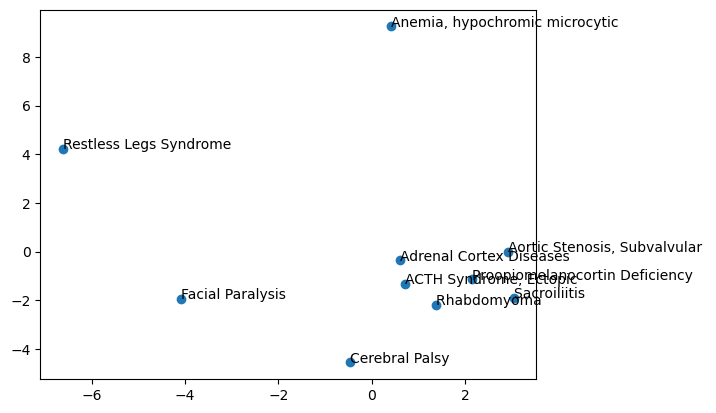

In [96]:
#nome_malattia    =  "MESH:D008223"   # LINFOMA
#nome_malattia    = "MESH:D003920"    # DIABETE
#nome_malattia    = "MESH:D010300"    # PARKINSON 
#nome_malattia    = "MESH:D001146"    # ARITMIA  
#nome_malattia    = "MESH:D000744"    # ANEMIA
#nome_malattia    = "MESH:D008180"    # LUPUS
nome_malattia     = "MESH:D012148"    # sindrome delle gambe senza riposo


malattia = V[np.array([diseases == nome_malattia]).argmax()]
distanze = np.linalg.norm( V - malattia, axis = 1 )
nomi_malattie = diseases
coppie   = np.c_[np.arange(len(diseases)),nomi_malattie,distanze]
coppie   = coppie[distanze.argsort()]
vicini   = np.array(coppie[:10])
V_vicini = np.array(V)[vicini[:,0].astype(int)]


from sklearn.manifold import MDS
embedding = MDS(n_components = 2).fit_transform(V_vicini)
plt.scatter(embedding[:,0],embedding[:,1])
for coppia,e in zip(coppie,embedding):
    mesh_id_symbol = coppia[1].split(':')[1]
    try:
        nome = get_mesh_title(mesh_id_symbol)
    except:
        print("something wrong")
        nome = coppia[1]
    print(nome)
    plt.annotate( nome ,e)


#V_vicini = V[np.array(vicini[:,0])]
#V_vicini



In [ ]:
D = jax.vmap(lambda a: jax.vmap(lambda b : (a- b)@(a- b) )(V))(V)
plt.imshow(D[:100,:100])

# ...

In [1]:
Image("V_packets.gif")

NameError: name 'Image' is not defined

DeviceArray([ 9.5361423e-01, -6.1987996e-01, -3.9550832e-01,
              3.7656292e-02, -7.2050667e-01,  2.8609219e+00,
             -6.3015497e-01, -1.3222121e+00, -7.1745801e-01,
              2.1004202e+00, -1.6559235e+00, -7.1673554e-01,
              1.1739066e+00, -2.6362026e-01,  2.7136809e-01,
              3.0968049e+00, -3.1395013e+00, -7.6196718e-01,
              2.0010176e+00, -1.3298546e+00,  8.5141617e-01,
              2.5888276e+00, -1.6211301e+00,  3.5964072e-01,
             -5.9087386e+00, -1.1728277e+00,  9.0638322e-01,
              7.2377676e-01,  7.3061955e-01,  3.6808057e+00,
              2.1824608e+00,  2.0509501e+00,  4.1559057e+00,
              5.7096523e-01, -2.9682722e+00,  5.3272009e-01,
              1.6279956e+00, -2.7602873e+00,  1.2806306e+00,
              1.2713455e-01,  4.0789112e-04, -1.6689125e+00,
             -2.4757993e+00, -1.6342949e+00, -2.0471020e+00,
             -6.9704428e-02,  1.6549261e+00, -4.8081741e-01,
              8.9835095e